In [ ]:
!pip install tensorflow tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
dataset, info = tfds.load("oxford_iiit_pet:4.0.0", with_info=True)
train_ds = dataset["train"]
test_ds = dataset["test"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.19D6RS_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.19D6RS_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 128

def preprocess(image, mask):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.int32) - 1
    return image, mask

train = train_ds.map(lambda x: preprocess(x["image"], x["segmentation_mask"]))
test = test_ds.map(lambda x: preprocess(x["image"], x["segmentation_mask"]))

train = train.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)
test = test.batch(16).prefetch(tf.data.AUTOTUNE)


In [ ]:
def unet():
    inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))

    c1 = tf.keras.layers.Conv2D(16,3,activation="relu",padding="same")(inputs)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(32,3,activation="relu",padding="same")(p1)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = tf.keras.layers.Conv2D(64,3,activation="relu",padding="same")(p2)

    u1 = tf.keras.layers.UpSampling2D()(c3)
    u1 = tf.keras.layers.Concatenate()([u1, c2])

    u2 = tf.keras.layers.UpSampling2D()(u1)
    u2 = tf.keras.layers.Concatenate()([u2, c1])

    outputs = tf.keras.layers.Conv2D(3,1,activation="softmax")(u2)

    return tf.keras.Model(inputs, outputs)

model = unet()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ concatenate[0][0] │
│ (UpSampling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 112)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        339 │ concatenate_1[0]… │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,923 (93.45 KB)

 Trainable params: 23,923 (93.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train, epochs=5, validation_data=test)


Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.6064 - loss: 0.8835 - val_accuracy: 0.6748 - val_loss: 0.7482
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6720 - loss: 0.7364 - val_accuracy: 0.6934 - val_loss: 0.7145
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.6915 - loss: 0.7012 - val_accuracy: 0.6956 - val_loss: 0.6919
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.6932 - loss: 0.6937 - val_accuracy: 0.7113 - val_loss: 0.6744
Epoch 5/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.7069 - loss: 0.6730 - val_accuracy: 0.7067 - val_loss: 0.6698


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


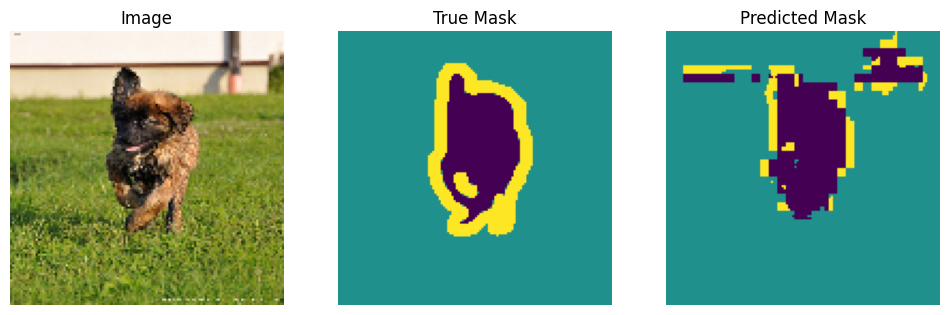

In [ ]:
def show_prediction():
    for img, mask in test.take(1):
        pred = model.predict(img)
        pred_mask = tf.argmax(pred, axis=-1)

        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.title("Image")
        plt.imshow(img[0])
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("True Mask")
        plt.imshow(mask[0])
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask[0])
        plt.axis("off")

        plt.show()

show_prediction()
